#### Importing GET-Pak

In [1]:
import getpak
from getpak import input, output, commons, methods

#### Importing libraries for path and plots

In [2]:
import matplotlib.pyplot as plt
import os

#### Loading the modules

In [3]:
# loading modules
utils = getpak.commons.Utils()
input = getpak.input.Input()
methods = getpak.methods.Methods()
output = getpak.output.Raster()

#### First step, declaring the paths (input and output)

In [4]:
grs_path = '/home/matheus/Documents/GET/Manuscript_GETPak/GRS/20240606/S2B_MSIL2Agrs_20240606T143749_N0510_R096_T20LLQ_20240606T161957.nc'
wd_path = '/home/matheus/Documents/GET/Manuscript_GETPak/water_masks/S2A_MSIL2A_20240611T143751_N0510_R096_T20LLQ_water_mask.tif'
imgs_out = '/home/matheus/Documents/GET/Manuscript_GETPak/outputs/'

#### Let's load the GRS image

In [5]:
grs_t = input.get_input_dict(file=grs_path, sensor='S2MSI', AC_processor='GRS', grs_version='v20')

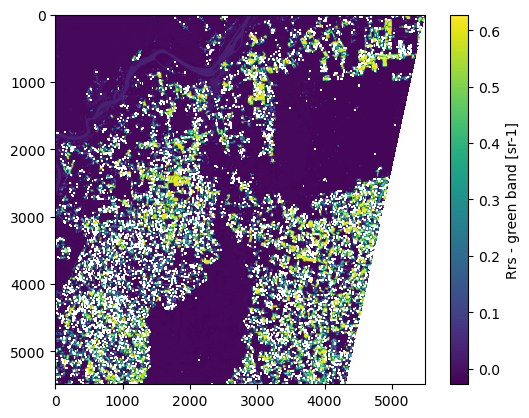

In [6]:
# plot
plt.imshow(grs_t['Green'], cmap="viridis")
plt.colorbar(label="Rrs - green band [sr-1]")
plt.show()

#### Exemple: mean of all pixels in band 5 (red-edge)

In [7]:
# example of computing: mean of B5
grs_t['RedEdge1'].mean().compute()

<xarray.DataArray 'RedEdge1' ()>
array(0.01729431, dtype=float32)
Coordinates:
    spatial_ref  int64 0

#### Opening the water mask and intersecting it with the GRS image

In [8]:
grs = methods.intersect_watermask(rrs_dict=grs_t, water_mask_dir=wd_path)

Done intersection with water mask.


/home/matheus/anaconda3/envs/py39/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 28.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


#### Let's visualise how the image has changed

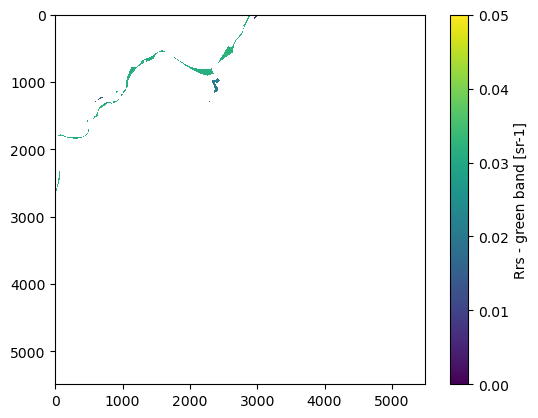

In [9]:
# plot
plt.imshow(grs['Green'], cmap="viridis", vmin=0, vmax=0.05)
plt.colorbar(label="Rrs - green band [sr-1]")
plt.show()

In [10]:
# computing mean of B5
grs['RedEdge1'].mean().compute()

<xarray.DataArray 'RedEdge1' ()>
array(0.0288306, dtype=float32)
Coordinates:
    spatial_ref  int64 0

#### Processing start: filtering 'bad' pixels

In [11]:
# minimum Rrs in the red band
grs['Red'].min().values

array(-0.02408999, dtype=float32)

In [12]:
grs = methods.filter_pixels(grs, neg_rrs='Red', low_rrs=None)

In [13]:
grs['Red'].min().values

array(2.9802322e-08, dtype=float32)

In [14]:
methods.negpix

10966

#### After this basic filtering, we are ready to apply the models! For the first test, let's apply a model specially developed for retrieving suspended particulate matter (SPM) from Sentinel-2 imagery in the Madeira river (Alves e Santos et al., 2024)

In [15]:
spm = methods.turb(rrs_dict=grs, class_owt_spt=None, alg='Madeira', limits=True)

/home/matheus/Documents/git_projects/get-pak/getpak/inversion_functions.py:283: RuntimeWarning: invalid value encountered in power
  spm = 945.1 * ((Nir2 / Red) ** 1.9463)


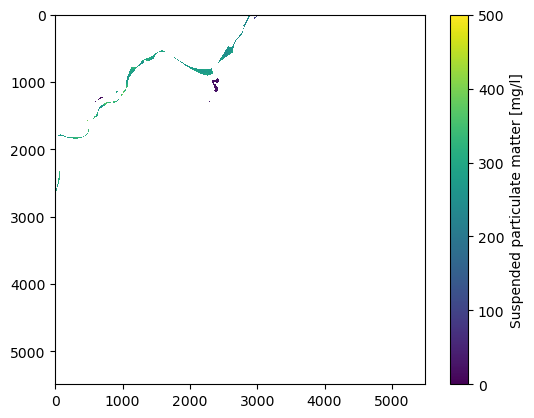

In [17]:
# plot
plt.imshow(spm, cmap="viridis", vmin=0, vmax=500)
plt.colorbar(label="Suspended particulate matter [mg/l]")
plt.show()

#### Saving this result (it can be further explored in a GIS software)

In [18]:
# Zero as no data
no_data = 0
# Name of the output file: 
str_output_file = os.path.join(imgs_out, "SPM_Madeira_GRS_20240606.tif")
# Saving as GeoTIFF
output.array2tiff(ndarray_data=spm, str_output_file=str_output_file, transform=grs.attrs['trans'], projection=grs.attrs['proj'], no_data=no_data)

#### Now let's try a chlorophyll-a (chla) model for eutrophic waters

In [19]:
chla_NDCI = methods.chlorophylla(rrs_dict=grs, class_owt_spt=None, limits=True, alg='ndci')

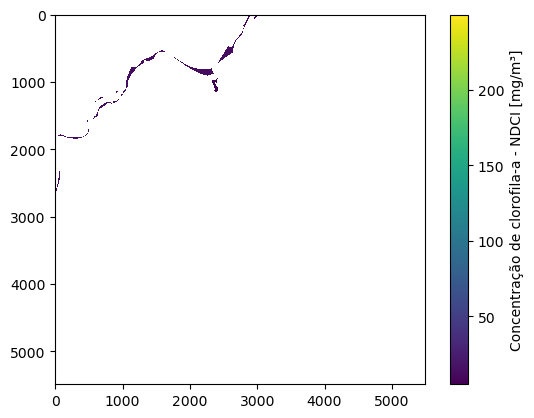

In [20]:
# plot
plt.imshow(chla_NDCI, cmap="viridis")
plt.colorbar(label="Concentração de clorofila-a - NDCI [mg/m³]")
plt.show()

In [21]:
# Zero as no data
no_data = 0
# Name of the output file: 
str_output_file = os.path.join(imgs_out, "Chla_NDCI.tif")
# Saving as GeoTIFF
output.array2tiff(ndarray_data=chla_NDCI, str_output_file=str_output_file, transform=grs.attrs['trans'], projection=grs.attrs['proj'], no_data=no_data)

#### Now trying a Optical Water Type-based model (actually a composition of different models)

In [22]:
# first classifying the pixels according to their OWT
classe_px, angles = methods.classify_owt_chla_px(rrs_dict=grs, sensor='S2MSI', B1=True)

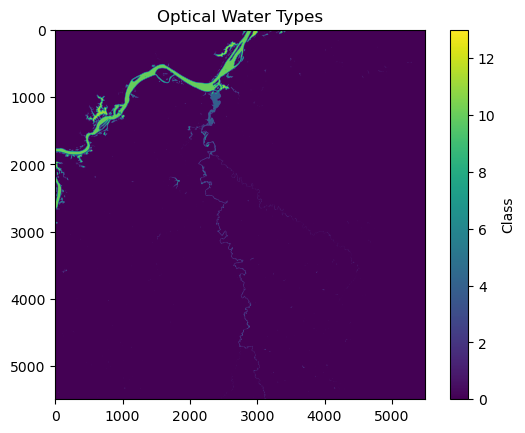

In [23]:
# plot
plt.imshow(classe_px, cmap="viridis")
plt.colorbar(label="Class")
plt.title("Optical Water Types")
plt.show()

In [24]:
# Zero as no data
no_data = 0
# Name of the output file: 
str_output_file = os.path.join(imgs_out, "OWTs.tif")
# Saving as GeoTIFF
output.array2tiff(ndarray_data=classe_px, str_output_file=str_output_file, transform=grs.attrs['trans'], projection=grs.attrs['proj'], no_data=no_data)

#### From these classes, we can create a homogeneised chla product

In [25]:
# Classes and weighs for the blended product
owt_classes, owt_weights = methods.classify_owt_chla_weights(class_px=classe_px, angles=angles, n=3)

In [26]:
# generating the chla product from these classes and weights
chla = methods.blended_chla(rrs_dict=grs, owt_classes, owt_weights, limits=True)

/home/matheus/Documents/git_projects/get-pak/getpak/inversion_functions.py:45: RuntimeWarning: invalid value encountered in power
  chl = ((RedEdge1 / Red) * (aw708 + bb) - aw665 - bb ** a) / b
/home/matheus/Documents/git_projects/get-pak/getpak/inversion_functions.py:20: RuntimeWarning: invalid value encountered in power
  chl = (0.7864 * (RedEdge1 / Red) / a - 0.4245 / a) ** b
/home/matheus/Documents/git_projects/get-pak/getpak/inversion_functions.py:82: RuntimeWarning: invalid value encountered in log10
  X = np.log10(Blue / Green)
/home/matheus/Documents/git_projects/get-pak/getpak/inversion_functions.py:83: RuntimeWarning: overflow encountered in power
  chl = 10 ** (a + b * X + c * X ** 2 + d * X ** 3 + e * X ** 4)
/home/matheus/Documents/git_projects/get-pak/getpak/methods.py:768: RuntimeWarning: invalid value encountered in divide
  chla = num / den


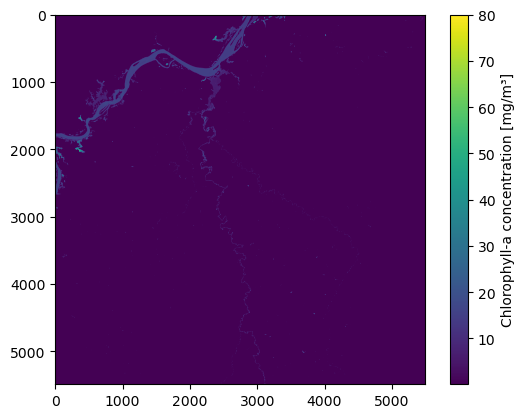

In [30]:
# plot
plt.imshow(chla, cmap="viridis", vmin=0.1, vmax=80)
plt.colorbar(label="Chlorophyll-a concentration [mg/m³]")
plt.show()

In [31]:
# Zero as no data
no_data = 0
# Name of the output file: 
str_output_file = os.path.join(imgs_out, "Chla_prod.tif")
# Saving as GeoTIFF
output.array2tiff(ndarray_data=chla, str_output_file=str_output_file, transform=grs.attrs['trans'], projection=grs.attrs['proj'], no_data=no_data)

In [32]:
# Close the client
grs_t.close()
grs.close()